# Tutorial: Build & Deploy Custom (fine-tuned) LLM Models and Applications

In the following tutorial you will learn how to operationalize a LLM using MLRun. We will build **MLOpsPedia** - The MLOps Master Bot, a chatbot for answering all your MLOps questions. We will do so by covering the two main stages in every MLOps project:

* **Automated training pipeline** - Build an automated ML pipeline for data collection, data preparation, training and evaluation.
* **Serving graph deployment** - Build, deploy and test in a Gradio application the newly trained LLM.

**MLRun** is welcoming you to **LLMOps**!

> Make sure you went over the basics in MLRun [Quick Start Tutorial](https://docs.mlrun.org/en/stable/tutorial/01-mlrun-basics.html) to understand the MLRun basics.

Run the notebook in the following order (you may skip the first step):
1. [Test the Pretrained Model](#test-the-pretrained-model)
2. [Automated Training Pipeline](#automated-training-pipeline)
3. [Application Serving Pipeline](#application-serving-pipeline)

But first, please install the following requirements:

In [ ]:
%pip install -r requirements.txt

___
<a id="test-the-pretrained-model"></a>
## 1. Test the Pretrained Model

MLOpsPedia will be based on [falcon-7b](https://huggingface.co/tiiuae/falcon-7b). Before fine-tuning it, we want to see how it performs on some MLOps questions.

### 1.1. Load `falcon-7b` from HuggingFace's Transformers Hub

`falcon-7b` is fully supported by HuggingFace and have its own Model and Tokenizer classes. We will use them in a HuggingFace pipeline and test them out:

In [1]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, pipeline
from transformers import logging
logging.set_verbosity("CRITICAL")

model_name = "tiiuae/falcon-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
generation_config = GenerationConfig.from_pretrained(model_name)
generator = pipeline("text-generation", model=model_name, tokenizer=tokenizer, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 1.2. Test it on some MLOps Questions

For the good order, we prepared `prompt_to_response` that infer a prompt through the pipeline we initialized and return the response. We'll use it for a couple of questions:

In [2]:
def prompt_to_response(prompt: str) -> str:
    return generator(prompt, 
                     generation_config=generation_config,
                     max_length=50, pad_token_id=tokenizer.eos_token_id)[0]["generated_text"]

In [3]:
print(prompt_to_response(prompt="What is a serving pipeline?"))

What is a serving pipeline?
A serving pipeline is a set of tools that help you to create, manage, and deliver your content.
What is a serving pipeline?
A serving pipeline is a set of tools that help you to create,


In [4]:
print(prompt_to_response(prompt="What is MLops?"))

What is MLops?
MLops is a set of practices that help organizations to build, deploy, and manage machine learning models at scale.
MLops is a set of practices that help organizations to build, deploy, and manage machine learning models


As expected, `falcon-7b` is not that sharp on MLOps questions, but that's about to change...

___
<a id="automated-training-pipeline"></a>
## 2. Automated Training Pipeline

To get a `falcon-7b` that knows MLOps, we will fine tune it on [**Iguazio**'s MLOps blogs](https://www.iguazio.com/blog/). To do so, we will create a fully automated pipeline with the following steps:

1. **Collect Data** - Collect all text from given html urls into `.txt` files, meaning we'll be getting all the MLOps blogs as text files.
2. **Preprocess Data** - Join the `.txt` files, reformatting the text into our prompt template: "Subject - Content". We made every header (`<h>` tags) a *subject* of a prompt, and the text (`<p>` tags) under it as its *content*.
3. **Train** - Fine-tune the LLM on the data. We'll run the training on **OpenMPI**, and we will use **DeepSpeed** for distributing the model and data between multiple workers, splitting the work between nodes and GPUs. **MLRun will auto-log the entire training process**.
4. **Evaluate** - Evaluate our model using the *Perplexity* metric.

<img src="./images/training-pipeline.png" style="width: 400px"/>

### 2.1. Define MLRun project and set all the MLRun functions

Create or load an MLRun project that holds all your functions and configuration (see [project_setup.py](./src/project_setup.py))

The project contains the following files where we'll set the functions from to build the workflow of the pipeline:
* [data_collection.py](./src/data_collection.py) - to create an MLRun function with the `collect_html_to_text_files` handler.
* [data_preprocess.py](./src/data_preprocess.py) - to create an MLRun function with the `prepare_dataset` handler.
* [training]() - to create an MLRun function with the `train` and `evaluate` handlers.
* [serving.py](./src/serving.py) - to create an MLRun function with all the serving graph steps (will be covered in section 3).

In addition, the training pipeline is set to the project as well. It can be seen at [training_workflow.py](./src/training_workflow.py)

The training and evaluation function we will use is [hugging_face_classifier_trainer](https://www.mlrun.org/hub/). It is taken from [**MLRun's Functions Hub**](https://docs.mlrun.org/en/stable/runtimes/load-from-hub.html) - a collection of ready to be imported functions for variety of use cases. We import the function during the project setup.

In [ ]:
import mlrun

project = mlrun.load_project(
    name="mlopspedia-bot",
    context="./",
    user_project=True,
    parameters={
        "source": "git://github.com/mlrun/demo-llm-tuning.git#main",
    })

git://github.com/mlrun/demo-llm-tuning.git#main


### 2.2. Run full LLM life-cycle workflow

Run the training pipeline by using `project.run(workflow name, ...)`. The steps on the piepline inputs and outputs are as follows:

1. url link -> `collect_html_to_text_files` -> zip containing all url text files.
2. zip containing all url text files -> `prepare_dataset` -> training set, evaluation set.
3. training set -> `train` -> model, metrics, plots
4. evaluation set, model -> `evaluate` -> metrics, plots

In [ ]:
# the absolute path to the file as it is in the local file system
html_links = "/User/demo-llm-tuning/data/html_urls.txt"

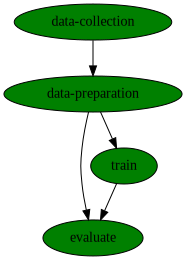

uid,start,state,name,parameters,results
...9eef349d,Jul 12 05:02:28,completed,evaluate,model_path=store://artifacts/mlopspedia-bot-yonis/falcon-7b-mlrun:2012a80c-500b-43fb-ad03-abffd6ee2a6bmodel_name=tiiuae/falcon-7btokenizer_name=tiiuae/falcon-7b,perplexity=8.5703125
...80920e39,Jul 12 03:56:11,completed,train,model_name=falcon-7b-mlrunpretrained_tokenizer=tiiuae/falcon-7bpretrained_model=tiiuae/falcon-7bmodel_class=transformers.AutoModelForCausalLMtokenizer_class=transformers.AutoTokenizerTRAIN_num_train_epochs=5use_deepspeed=,loss=2.3346learning_rate=0.0train_runtime=3898.6792train_samples_per_second=0.737train_steps_per_second=0.046total_flos=2.9304526258176e+16
...0ffbf5ab,Jul 12 03:55:46,completed,data-preparation,,
...7dea94d6,Jul 12 03:53:50,completed,data-collection,urls_file=/User/demo-llm-tuning/data/html_urls.txt,


In [ ]:
workflow_run = project.run(
    name="training_workflow",
    arguments={
        "html_links": html_links,
        "model_name": "falcon-7b-mlrun",
        "pretrained_tokenizer": model_name,
        "pretrained_model": model_name,
        "epochs": 5,
    },
    watch=True,
    dirty=True,
    timeout=60 * 120,
)

#### 2.2.1. Distributed Training

In the following image you can see the 16 workers that trained the model as part of an **MPIJob** and **DeepSpeed**.

<img src="./images/16-workers-training.png" style="width: 1000px"/>

#### 2.2.2. UI Presentation

Here we can see how the workflow looks on our UI, we can see the entire pipeline and the loss plot produced by the training step that is highlighted.

<img src="./images/workflow-train.png" style="width: 1000px"/>

___
<a id="application-serving-pipeline"></a>
## 3. Application Serving Pipeline

In this last part we'll serve our LLM using [MLRun Serving](https://docs.mlrun.org/en/stable/serving/serving-graph.html).

MLRun serving can produce managed ML application pipelines using real-time auto-scaling [Nuclio](https://nuclio.io/) serverless functions. The application pipeline includes all the steps from accepting events or data, preparing the required model features, inferring results using one or more models, and driving actions.

We'll build the following serving graph for chat application:

* **Preprocess** (`preprocess`) - Fit the user prompt into out prompt structure ("Subject - Content") 
* **LLM** (`LLMModelServer`) - To serve our trained model and perform inferences to generate answers.
* **Postprocess** (`postprocess`) - To see if our model generated text with confidence or not.
* **Toxicity Filter** (`ToxicityClassifierModelServer`) - To serve a Hugging Face Evaluate package model and perform inferences to catch toxic prompt and responses.

<img src="./images/serving-graph.png" style="width: 800px"/>

### 3.1. Build our Serving Graph

We'll first get the serving function with the code from our project (it was set in section 2.1.):

In [7]:
serving_function = project.get_function("serving")

In [8]:
model_args = {"load_in_8bit": True, "device_map": "cuda:0", "trust_remote_code": True}

Now we'll build the serving graph:

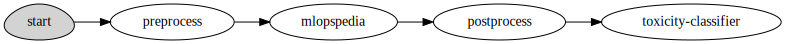

In [9]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Add the steps:
graph.to(handler="preprocess", name="preprocess") \
     .to("LLMModelServer",
         name="mlopspedia",
         model_args=model_args,
         tokenizer_name=model_name,
         model_name=model_name,
         peft_model=project.get_artifact_uri("falcon-7b-mlrun")) \
     .to(handler="postprocess", name="postprocess") \
     .to("ToxicityClassifierModelServer",
         name="toxicity-classifier",
         threshold=0.7).respond()

# Plot to graph:
serving_function.plot(rankdir='LR')

Lastly, we wish to add a GPU and save the configured function in the project:

In [10]:
# Configure (add a GPU and increase readiness timeout):
serving_function.with_limits(gpus=1)
serving_function.spec.readiness_timeout = 3000

# Save the function to the project:
project.set_function(serving_function, with_repo=True)
project.save()

### 3.2. Deploy and Test the Application

We will call the `deploy_function` and wait:

In [11]:
# Deploy the serving function:
deployment = mlrun.deploy_function("serving")

> 2023-07-12 05:03:41,703 [info] Starting remote function deploy
2023-07-12 05:03:42  (info) Deploying function
2023-07-12 05:03:42  (info) Building
2023-07-12 05:03:42  (info) Staging files and preparing base images
2023-07-12 05:03:42  (info) Building processor image
2023-07-12 05:26:38  (info) Build complete
2023-07-12 05:42:21  (info) Function deploy complete
> 2023-07-12 05:42:23,182 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-mlopspedia-bot-yonis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['mlopspedia-bot-yonis-serving-mlopspedia-bot-yonis.default-tenant.app.llm2.iguazio-cd0.com/']}


Let's test the function manually on some prompts:

In [12]:
generate_kwargs = {"max_length": 150, "temperature": 0.9, "top_p": 0.5, "top_k": 25, "repetition_penalty": 1.0}

In [13]:
response = serving_function.invoke(path='/predict', body={"prompt": "What is MLRun?", **generate_kwargs})
print(response["outputs"])

> 2023-07-12 05:42:23,239 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mlopspedia-bot-yonis-serving.default-tenant.svc.cluster.local:8080/predict'}
MLRun is a complete open source MLOps orchestration platform that provides a single platform for building, training, deploying and managing ML applications at scale. MLRun is built on top of Iguazio’s open source data science platform and provides a unified framework for running data science and ML applications.
MLRun provides:

A single place to run and manage all ML workloads (from data science to production)
A unified framework for running data science and ML applications
A single place to run and manage all ML workloads (from data science to production)
A unified framework for running data science and ML applications
A unified framework for running data science and


In [14]:
response = serving_function.invoke(path='/predict', body={"prompt": "What is machine learning?", **generate_kwargs})
print(response["outputs"])

> 2023-07-12 05:42:45,916 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mlopspedia-bot-yonis-serving.default-tenant.svc.cluster.local:8080/predict'}
Machine learning is a subfield of artificial intelligence (AI) that focuses on algorithms that can learn from data and improve their performance over time. Machine learning algorithms can be used to build intelligent systems that can make decisions, learn from experience, and adapt to new situations.
Machine learning algorithms are used in many areas of our daily lives, such as:

Automated driving
Speech recognition
Image recognition
Personalized recommendations

Machine learning algorithms are used in the development of autonomous cars. The cars are able to navigate roads and react to situations in real time.
Speech recognition algorithms are used in voice assistants like Siri and Alexa. They can recognize your voice


In [15]:
response = serving_function.invoke(path='/predict', body={"prompt": "You are stupid!", **generate_kwargs})
print(response["outputs"])

> 2023-07-12 05:43:06,514 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mlopspedia-bot-yonis-serving.default-tenant.svc.cluster.local:8080/predict'}
This bot do not respond to toxicity.


Now, we'll set up a Gradio application and launch it:

In [16]:
import json

import gradio as gr
import requests

# Get the serving url to send requests to:
serving_url = deployment.outputs["endpoint"]


def generate(prompt, temperature, max_length, top_p, top_k, repetition_penalty):
    # Build the request for our serving graph:
    inputs = {
        "prompt": prompt,
        "temperature": temperature,
        "max_length": max_length,
        "top_p": top_p,
        "top_k": top_k,
        "repetition_penalty": repetition_penalty,
    }

    # call the serving function with the request:
    resp = requests.post(serving_url, data=json.dumps(inputs).encode("utf-8"))

    # Return the response:
    return resp.json()["outputs"]


# Set up a Gradio frontend application:
with gr.Blocks(analytics_enabled=False, theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """# LLM Playground
Play with the `generate` configurations and see how they make the LLM's responses better or worse.
"""
    )
    with gr.Row():
        with gr.Column(scale=5):
            with gr.Row():
                chatbot = gr.Chatbot()
            with gr.Row():
                prompt = gr.Textbox(label="Subject to ask about:", placeholder="Type a question and Enter")

        with gr.Column(scale=1):
            temperature = gr.Slider(minimum=0, maximum=1, value=0.9, label="Temperature", info="Choose between 0 and 1")
            max_length = gr.Slider(minimum=0, maximum=1500, value=150, label="Maximum length", info="Choose between 0 and 1500")
            top_p = gr.Slider(minimum=0, maximum=1, value=0.5, label="Top P", info="Choose between 0 and 1")
            top_k = gr.Slider(minimum=0, maximum=500, value=25, label="Top k", info="Choose between 0 and 500")
            repetition_penalty = gr.Slider(minimum=0, maximum=1, value=1, label="repetition penalty", info="Choose between 0 and 1")
            clear = gr.Button("Clear")

    def respond(prompt, chat_history, temperature, max_length, top_p, top_k, repetition_penalty):
        bot_message = generate(prompt, temperature, max_length, top_p, top_k, repetition_penalty)
        chat_history.append((prompt, bot_message))

        return "", chat_history

    prompt.submit(respond, [prompt, chatbot, temperature, max_length, top_p, top_k, repetition_penalty], [prompt, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)


In [17]:
demo.launch(share=True, height=685)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://b47d16a4d0489c6dde.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<img src="./images/gradio.png" style="width: 1000px"/>